In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import utils
from classify_svhn import get_data_loader

import scipy.io
from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

print(f"Your version of Pytorch is {torch.__version__}. You should use a version >0.4.") #Check

cuda
Your version of Pytorch is 1.0.1.post2. You should use a version >0.4.


## Download

In [0]:
### Run once, then comment.

subprocess.call([
     "wget", "-P", "./data/",
     "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
 ])

subprocess.call([
     "wget", "-P", "./data/",
     "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
 ])

0

## Load

In [0]:
#trainloader, validloader, testloader = get_data_loader("data",128)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [0]:
def load_amat(path):
    mat = scipy.io.loadmat(path)
    x = mat['X']
    y = mat['y']
    x = np.moveaxis(x, 3, 0)
    x = np.moveaxis(x, 3, 1)
    x = x / 255
    return x.astype(np.float32), y

x_train, y_train = load_amat("data/train_32x32.mat")
x_test, _ = load_amat("data/test_32x32.mat")

x_train, x_val = train_test_split(x_train, test_size=0.1, stratify=y_train)
print(x_train.shape)

Batch_size = 128

#train_data=[]
#for i in range(x_train.shape[0]):
#  train_data.append((x_train[i],y_train[i]))

trainloader = DataLoader(x_train, batch_size=Batch_size , shuffle=True)
validloader = DataLoader(x_val, batch_size=Batch_size , shuffle=False)

(65931, 3, 32, 32)


torch.Size([3, 32, 32])


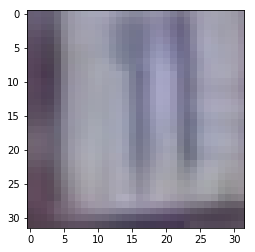

In [0]:
for isdfd,example in enumerate(trainloader):
  print(example[0].shape)
  #print(example[0])
  plt.imshow(example[0].permute(1,2,0))
  break


In [0]:
class VAE_SVHN(nn.Module):
    def __init__(self,d=128):
        super(VAE_SVHN, self).__init__()
        
        self.d = d
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1,bias=False)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1,bias=False)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1,bias=False)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1,bias=False)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*8, 4, 2, 1,bias=False)
        
        
        self.deconv1 = nn.ConvTranspose2d(d*8, d*8, 4, 2, 1, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1,bias=False)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1,bias=False)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1,bias=False)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1,bias=False)
        
        self.h1_1 = nn.Linear(d*8,d*4)                   #output mu and logvar
        self.h1_2 = nn.Linear(d*4,200)

        
        self.h2_1=nn.Linear(100,d*4)
        self.h2_2=nn.Linear(d*4,d*8)


        
    def forward(self,x):
      x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
      x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
      x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
      x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
      x = self.conv5(x)
        
      q = self.h1_2(self.h1_1(x.view(-1,self.d*8)))
      mu,logvar = torch.split(q,100,dim=1)
      
      std = (logvar*0.5).exp()
      eps = torch.randn_like(mu).to(device)
      z = mu + (eps*std)
      
      x_ = (self.h2_2(self.h2_1(z))).view(-1,self.d*8,1,1)
      x_ = F.leaky_relu(self.deconv1_bn(self.deconv1(x_)), 0.2)
      x_ = F.leaky_relu(self.deconv2_bn(self.deconv2(x_)), 0.2)
      x_ = F.leaky_relu(self.deconv3_bn(self.deconv3(x_)), 0.2)
      x_ = F.leaky_relu(self.deconv4_bn(self.deconv4(x_)), 0.2)
      x_ = self.deconv5(x_)
      
      
      return x_, mu, logvar
      
    def generate_new_data(self,z):
      """ The following function take the z sampled from distribution and generate new examples
              
      """
      with torch.no_grad():    #no gradients to accumulate here, i.e. faster
        x_ = (self.h2_2(self.h2_1(z))).view(-1,self.d*8,1,1)      
        x_ = F.leaky_relu(self.deconv1_bn(self.deconv1(x_)), 0.2)
        x_ = F.leaky_relu(self.deconv2_bn(self.deconv2(x_)), 0.2)
        x_ = F.leaky_relu(self.deconv3_bn(self.deconv3(x_)), 0.2)
        x_ = F.leaky_relu(self.deconv4_bn(self.deconv4(x_)), 0.2)
        return self.deconv5(x_)
        
      
def loss_function(x_,x,mu,logvar):
  """ The Loss is a combination of the reconstruction loss 
      and the KLD.
  """
  k = 3*32*32
  
  RL = k/2 * torch.log(2 * np.pi * torch.ones(1).to(device)) +0.5 *F.mse_loss(x_, x, reduction='sum')
  
  KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
  
  return (RL+KLD)/x.shape[0]

In [0]:
clf = VAE_SVHN(100)
cuda_available = torch.cuda.is_available()
print(cuda_available)
if cuda_available:
    clf = clf.cuda()
optimizer = optim.Adam(clf.parameters(),lr=3e-4)
criterion = loss_function

True


In [0]:
## Let's train for 20 epochs

best = 1000
tracking_loss=[]
for epoch in range(20):
  
  training_loss=0
  for batch_idx, x in enumerate(trainloader):
    x = x.to(device)
    optimizer.zero_grad()
    
    #Proper training
    x_, mu, logvar = clf(x)

    loss = criterion(x_, x, mu, logvar)
    loss.backward()
    training_loss += loss.item()
    optimizer.step()
    
    if (batch_idx+1) % 52 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tELBO: {:.6f}'.format(
            epoch, batch_idx * len(x), len(trainloader.dataset),
            100. * batch_idx / len(trainloader),
            -1*loss.item()))
  train_batches = batch_idx

  tracking_loss.append(training_loss)
  clf.eval()
  valid_loss=0
  for batch_idx, x in enumerate(validloader):
    x = x.to(device)
    x_, mu, logvar = clf(x)
    loss = criterion(x_, x, mu, logvar)
    valid_loss += loss.item()
  valid_batches = batch_idx
  clf.train()
  
  this_run = valid_loss/valid_batches
  
  if this_run<best :
      best_params = clf.state_dict() 
  print('====> Epoch: {} Avg ELBO on Train: {:.4f} || Avg ELBO on Valid: {:.4f}'.format(
      epoch, -1*training_loss/train_batches, -1*valid_loss/valid_batches ))

Train Epoch: 0 [6528/65931 (10%)]	ELBO: -62.889935
Train Epoch: 0 [13184/65931 (20%)]	ELBO: -56.242470
Train Epoch: 0 [19840/65931 (30%)]	ELBO: -56.364433
Train Epoch: 0 [26496/65931 (40%)]	ELBO: -50.946983
Train Epoch: 0 [33152/65931 (50%)]	ELBO: -48.778023
Train Epoch: 0 [39808/65931 (60%)]	ELBO: -48.243454
Train Epoch: 0 [46464/65931 (70%)]	ELBO: -48.039604
Train Epoch: 0 [53120/65931 (80%)]	ELBO: -50.098763
Train Epoch: 0 [59776/65931 (91%)]	ELBO: -47.292221
====> Epoch: 0 Avg ELBO on Train: -72.2698 || Avg ELBO on Valid: -50.6442
Train Epoch: 1 [6528/65931 (10%)]	ELBO: -48.475574
Train Epoch: 1 [13184/65931 (20%)]	ELBO: -47.791218
Train Epoch: 1 [19840/65931 (30%)]	ELBO: -46.665798
Train Epoch: 1 [26496/65931 (40%)]	ELBO: -45.546970
Train Epoch: 1 [33152/65931 (50%)]	ELBO: -46.339500
Train Epoch: 1 [39808/65931 (60%)]	ELBO: -47.038239
Train Epoch: 1 [46464/65931 (70%)]	ELBO: -46.280113
Train Epoch: 1 [53120/65931 (80%)]	ELBO: -44.857063
Train Epoch: 1 [59776/65931 (91%)]	ELBO: -47

In [0]:
torch.save(best_params,"../VAE_3_tobito.pt")

## Loading model if needed

In [0]:
clf.load_state_dict(torch.load("../VAE_3_newdim.pt"))

## Generating examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

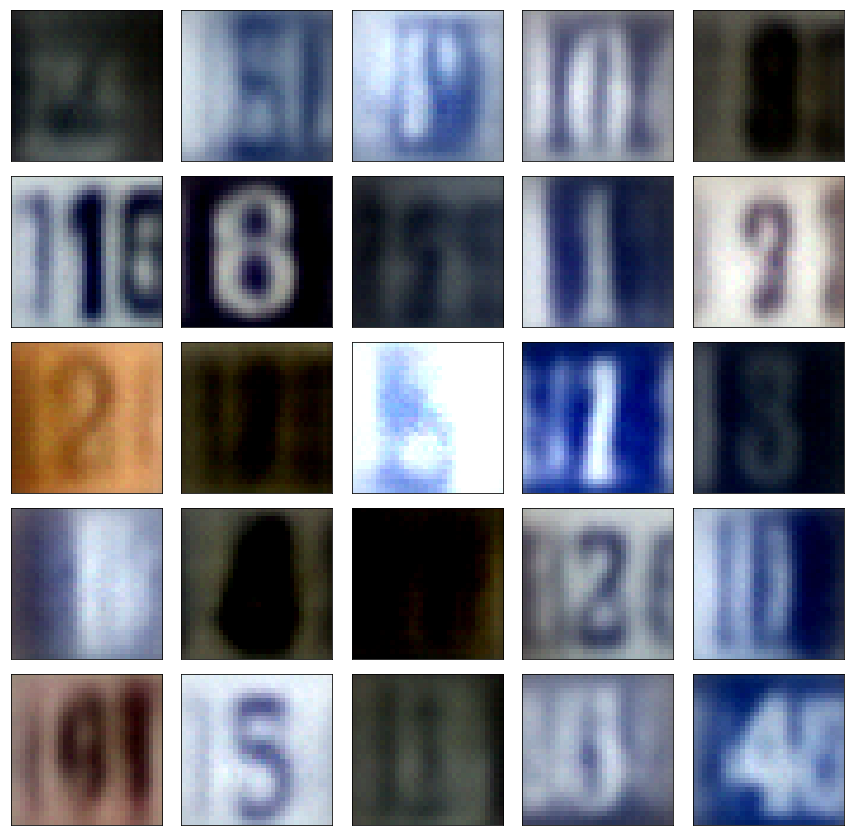

In [0]:
fig,axis = plt.subplots(5,5,figsize=(15,15))
for i in range(25):
  example = torch.normal(torch.zeros(100),1).cuda()
  img = clf.generate_new_data(example)
  img = img.view(3,32,32)/2 + 0.5
  img = img.cpu().permute(1,2,0)
  
  axis[i//5, i%5].imshow(img)
  axis[i//5, i%5].get_xaxis().set_ticks([])
  axis[i//5, i%5].get_yaxis().set_ticks([])
  axis[i//5, i%5].set_aspect('equal')
  
fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show() 

## Disentangled Representation

torch.Size([100])
torch.Size([1, 3, 32, 32])


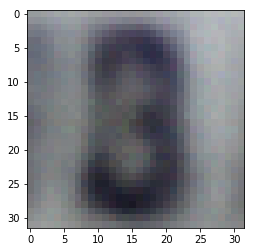

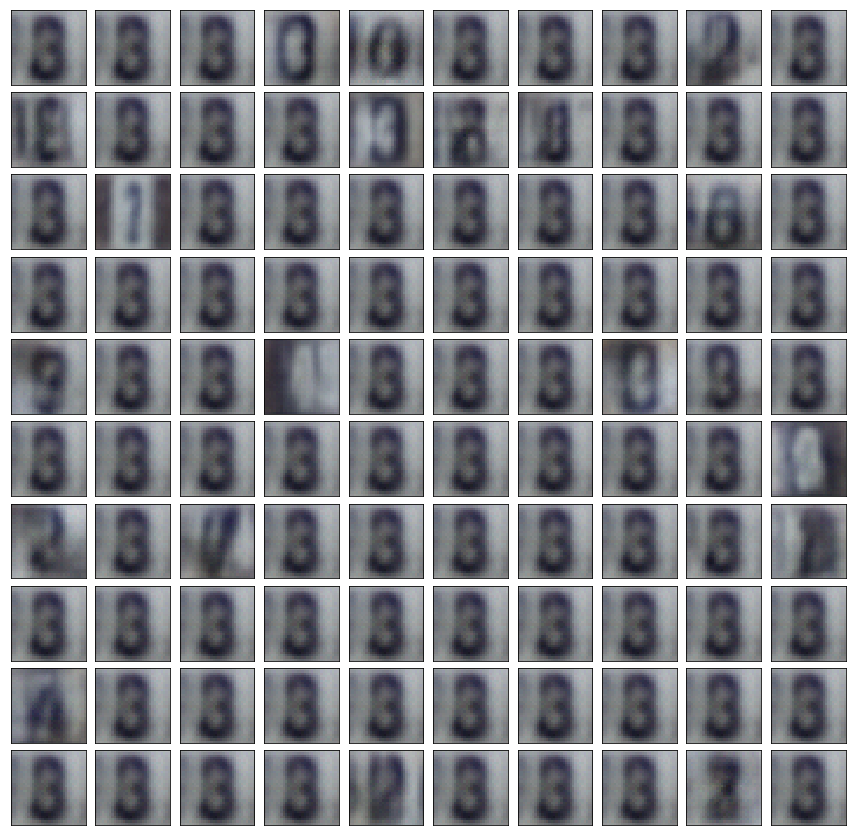

tensor([ 8.7785e-01, -1.2263e+00,  1.7204e-01,  1.3273e+00, -5.3669e-01,
        -7.7421e-01,  3.0810e+00, -9.7318e-01, -1.3558e+00,  5.4332e-01,
         5.3640e-01, -2.0487e-01,  3.8621e-01,  5.2227e-01,  2.9977e-01,
        -1.6734e+00,  1.0217e-01, -1.4995e+00,  1.1410e-01,  8.8561e-01,
         1.4375e-01, -1.5381e+00, -1.2206e+00,  6.0804e-01,  8.7225e-01,
         8.3174e-02, -6.6466e-02,  7.9306e-01,  1.0491e+00, -8.7191e-01,
        -3.7267e-01,  1.0259e+00, -9.6994e-01, -2.3281e-03, -4.4477e-01,
        -1.8099e+00,  4.5447e-01,  1.0847e-01,  4.1219e-01,  1.1242e-01,
        -9.4585e-01, -5.0590e-01, -7.8800e-01, -1.9499e-01, -6.3879e-01,
         1.1001e+00,  8.5918e-01, -1.8987e+00,  2.3229e-01, -2.0472e-01,
         3.3146e-01,  4.0087e-03,  5.4736e-01,  7.4610e-01, -1.3159e+00,
         1.0072e+00, -4.7858e-01,  3.1463e-01,  6.8153e-01, -1.4160e+00,
         1.6217e+00, -1.2569e+00,  4.9672e-01,  7.3125e-02,  1.0219e+00,
        -7.4198e-02,  8.5870e-01,  8.9674e-01, -6.8

In [0]:
##### Disentangled Representation


zz = torch.normal(torch.zeros(100),1).to(device)
print(zz.shape)
test_img = clf.generate_new_data(zz)
print(test_img.shape)
test_img = test_img.view(3,32,32)
plt.imshow(test_img.cpu().permute(1,2,0)/2 + 0.5)

## Let's explore the dimensions
variation = 10

fig, axis = plt.subplots(10,10,figsize=(15,15))
for i in range(100):
  perturbed = zz.clone().detach()
  perturbed[i] = perturbed[i] + variation
  
  slide_img = clf.generate_new_data(perturbed)
  slide_img = slide_img.view(3,32,32)
  slide_img = slide_img.cpu().permute(1,2,0)/2 + 0.5
  
  axis[i//10, i%10].imshow(slide_img)
  axis[i//10, i%10].get_xaxis().set_ticks([])
  axis[i//10, i%10].get_yaxis().set_ticks([])
  axis[i//10, i%10].set_aspect('equal')
  
fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()  
#print(zz)
#print(perturbed)

## Interpolating data space\latent space

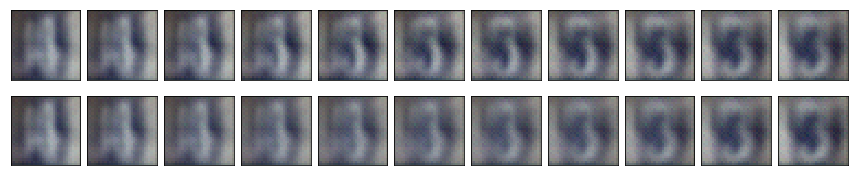

In [0]:
z0 = torch.normal(torch.zeros(100),1).to(device)
z1 = torch.normal(torch.zeros(100),1).to(device)

g0 = clf.generate_new_data(z0)
g0 = g0.view(3,32,32)
g0 = g0.cpu().permute(1,2,0)/2 + 0.5

g1 = clf.generate_new_data(z1)
g1 = g1.view(3,32,32)
g1 = g1.cpu().permute(1,2,0)/2 + 0.5

alpha = np.linspace(0,1,11)

##Walking in z space

fig1, axis = plt.subplots(2,11,figsize=(15,3))

for i in range(11):
  walk = alpha[i]*z0 + (1-alpha[i])*z1
  walk_img = clf.generate_new_data(walk)
  walk_img = walk_img.view(3,32,32)
  walk_img = walk_img.cpu().permute(1,2,0)/2 + 0.5
  
  axis[0,i].imshow(walk_img)
  axis[0,i].get_xaxis().set_ticks([])
  axis[0,i].get_yaxis().set_ticks([])
  axis[0,i].set_aspect('equal')
  
  walk_img2 = alpha[i]*g0 + (1-alpha[i])*g1
  
  axis[1,i].imshow(walk_img2)
  axis[1,i].get_xaxis().set_ticks([])
  axis[1,i].get_yaxis().set_ticks([])
  axis[1,i].set_aspect('equal')
  
fig1.subplots_adjust(wspace=0.1, hspace=0.1)
fig1.show()  
 

In [0]:
import torchvision

base_path = "../content/smaller_data/VAE_example"
with torch.no_grad():
  for i in range(100):
    clf.eval()
    zz = torch.normal(torch.zeros(100),1).cuda()
    img = clf.generate_new_data(zz)
    img = (img.cpu().view(3,32,32))#/2 + 0.5
    #img = img.cpu().permute(1,2,0)
    torchvision.utils.save_image(img,base_path+str(i+1)+".jpg",normalize=True)
    

In [0]:
!zip -r /content/VAE.zip /content/smaller_data

  adding: content/smaller_data/ (stored 0%)
  adding: content/smaller_data/VAE_example29.jpg (deflated 20%)
  adding: content/smaller_data/VAE_example7.jpg (deflated 22%)
  adding: content/smaller_data/VAE_example55.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example45.jpg (deflated 22%)
  adding: content/smaller_data/VAE_example52.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example91.jpg (deflated 22%)
  adding: content/smaller_data/VAE_example85.jpg (deflated 20%)
  adding: content/smaller_data/VAE_example84.jpg (deflated 23%)
  adding: content/smaller_data/VAE_example93.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example44.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example8.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example78.jpg (deflated 22%)
  adding: content/smaller_data/VAE_example31.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example96.jpg (deflated 21%)
  adding: content/smaller_data/VAE_example76.jpg (deflated 22%

In [0]:
!mkdir "../content/smaller_data"